In [38]:
#The libraries needed to run the code and camb. 
import math
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb

#Noise curves for 2019-2020 servay from Srini
d = np.load('spt3g_winter_2020_ilc_cmb_90-150-220_TT-EE.npy', allow_pickle=True)
dd = d.item()

# Dictionaries for Cosmological Parameters. 
# Each Dictionary is named after the variable we are varrying by 1 percent. 

cos_dict = {'H0': 67.5, 'ombh2':0.022, 'omch2':0.122,'mnu': 0.06,'omk': 0 , 'tau': 0.06}
H0_dict ={'H0': 67.5*1.01, 'ombh2':0.022, 'omch2':0.122, 'mnu': 0.06,'omk': 0, 'tau': 0.06}
ombh2_dict = {'H0': 67.5, 'ombh2':0.022*1.01, 'omch2':0.122,'mnu': 0.06,'omk': 0, 'tau': 0.06}
omch2_dict={'H0': 67.5, 'ombh2':0.022, 'omch2':0.122*1.01, 'mnu': 0.06,'omk': 0, 'tau': 0.06}
tau_dict = {'H0': 67.5, 'ombh2':0.022, 'omch2':0.122, 'mnu': 0.06,'omk': 0, 'tau': 0.06*1.01}

  
    
def get_cl(dict, Gmu, b, c):
    """ The function get_cl finds the covariant matrix. 
    
        Parameters: 
        dict(dictinary): is the dictionary of cosmological parameters. 
        b(int): is the factor As is varied by. 
        c(int): is the factor ns is varied by. 
        
        Returns: 
        np.matrix: the matrix represents the covarient matrix. 
        """ 
        pars = camb.CAMBparams()
        cl_matrix = []
        pars.set_cosmology(**dict)
        pars.InitPower.set_params(As=b*2.10058296e-9, ns=c*0.96605, r =0)
        pars.set_for_lmax(10000, lens_potential_accuracy=0);
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
        totCL=powers['total']
        unlensedCL=powers['unlensed_scalar']
        ls = np.arange(totCL.shape[0])
        unlensedCL=powers['unlensed_scalar']
        cl_t = totCL[:,0]
        cl_e =totCL[:,1]
        cl_te = totCL[:,3]
        noiseTT = dd['cl_residual']['TT']
        noiseEE = dd['cl_residual']['EE']
        SigmaTot_tt2 = 0
        SigmaStr_tt2 = 0
        for i in range(2,len(yt)):
            SigmaTot_tt2 += ((2*i+1)/(4*np.pi))* ((cl_t[i] *(2*np.pi))/(i*(i+1)))
            SigmaStr_tt2 += ((2*i+1)/(4*np.pi))* ( (yt[i]+ zt[i]+tt[i])*((2*np.pi))/(i*(i+1)))
        A = Gmu**2 * SigmaTot_tt2 *(1.27*10**(-6))**(-2) *(SigmaStr_tt2)**(-1)
        for i in ls[(ls < len(noiseTT)) & (ls < len(cl_t))& (ls <len(yt)) & (ls > 100)]:
            Cl_11 = A*(yt[i]+ zt[i]+tt[i])*((2*np.pi)/(i*(i+1)))+noiseTT[i] + ((cl_t[i]*(2*np.pi))/(i*(i+1)))
            Cl_12 = A*(yte[i]+ zte[i]+te[i])*((2*np.pi)/(i*(i+1)))+((cl_te[i]*(2*np.pi))/(i*(i+1)))
            Cl_22 = A*(ye[i]+ ze[i]+te[i])*((2*np.pi)/(i*(i+1)))+noiseEE[i] + ((cl_e[i]*(2*np.pi))/(i*(i+1)))
            c_l   = np.matrix([[Cl_11,  Cl_12],[ Cl_12, Cl_22]])
            cl_matrix.insert(len(cl_matrix)-1,c_l)
        return cl_matrix

H0_cls = get_cl(H0_dict, 1*10**(-7),1, 1)
cos_cls = get_cl(cos_dict, 1*10**(-7),1,1)
Gmu_cls = get_cl(cos_dict, 1*10**(-7)*1.01,1,1)
ombh2_cls = get_cl(ombh2_dict, 1*10**(-7),1, 1)
omch2_cls = get_cl(omch2_dict,1*10**(-7), 1,1)
As_cls = get_cl(cos_dict,1*10**(-7),1.01,1)
ns_cls = get_cl(cos_dict, 1*10**(-7),1,1.01)
tau_cls = get_cl(tau_dict,1*10**(-7),1,1)
cl_dict = {"H0": H0_cls, "ombh2": ombh2_cls ,"omch2": omch2_cls, "As":As_cls, "ns":ns_cls, "tau":tau_cls, "Gmu":Gmu_cls, "cos": cos_cls}  
cl_dict_values = {"H0": 67.5, "ombh2": 0.022  ,"omch2": 0.122, "As":2.10058296e-9, "ns":0.96605, "tau":0.06, "Gmu":1*10**(-7)} 
var = list(cl_dict.keys())
f_matrix1 = np.zeros((7,7))
for row in range(7):
    for column in range(7):
        for i in range(1,2898):
                Clinv = np.linalg.inv((cl_dict[var[7]])[i])
                dCldtheta_row = ((((cl_dict[var[row]])[i]) - ((cl_dict[var[7]])[i])) / ((0.01)*cl_dict_values[var[row]]))
                dCldtheta_column = ((((cl_dict[var[column]])[i]) - ((cl_dict[var[7]])[i])) / ((0.01)*cl_dict_values[var[column]]))
                fsky =1500 / 41253
                f_matrix1[row,column] += ((2*i+1)/2) * fsky * np.trace(Clinv * dCldtheta_row * Clinv * dCldtheta_column)
    
print(f_matrix1)

[[ 4.21519861e+02 -4.57929163e+05  1.51788612e+05 -3.43852306e+12
  -7.78091557e+03  1.34475175e+04 -2.44005393e+09]
 [-4.57929163e+05  8.44160935e+08 -1.56145512e+08  6.99586127e+15
   1.84213015e+07 -2.73786619e+07  6.01303041e+12]
 [ 1.51788612e+05 -1.56145512e+08  5.68519464e+07 -1.47976379e+15
  -2.83825182e+06  5.88571221e+06 -8.48097740e+11]
 [-3.43852306e+12  6.99586127e+15 -1.47976379e+15  2.01726461e+23
   3.58144791e+14 -7.96374595e+14  1.08016008e+20]
 [-7.78091557e+03  1.84213015e+07 -2.83825182e+06  3.58144791e+14
   7.99528552e+05 -1.41460902e+06  2.31516711e+11]
 [ 1.34475175e+04 -2.73786619e+07  5.88571221e+06 -7.96374595e+14
  -1.41460902e+06  3.15757316e+06 -4.17576566e+11]
 [-2.44005393e+09  6.01303041e+12 -8.48097740e+11  1.08016008e+20
   2.31516711e+11 -4.17576566e+11  9.73736831e+16]]


In [18]:
def prior(row,column, value, matrix):
    """The function adds a value to the defined value of the matrix . 
    
        Parameters: 
        row(int): specfies the row of the matrix.
        column(int): specifies the column of the matrix.
        value(int): the value added to the element specified by the row and column.
        matrix(np matrix): is the cl_matrix from get_cls
        
        Returns: 
        np.matrix: returns the covarient matrix with the updated value of the specified row and column."""
    matrix[row,column] +=   (1/value**2)
    return matrix
        

def error(matrix):    
    """The function adds a value to the defined value of the matrix . 
    
        Parameters: 
        matrix(np matrix): is updated matrix after adding a prior.
        
        Returns: 
        np.matrix: the uncertainities constraints on all the cosmological parameters."""

    a = np.linalg.inv(matrix)
    a.diagonal()
    for i in range(0, len(a.diagonal())): 
        errors = {}
        errors[i] = (a.diagonal()[i])**(1/2)
        print(errors)

In [39]:
prior(5,5,0.0070, f_matrix1)


array([[ 4.21519861e+02, -4.57929163e+05,  1.51788612e+05,
        -3.43852306e+12, -7.78091557e+03,  1.34475175e+04,
        -2.44005393e+09],
       [-4.57929163e+05,  8.44160935e+08, -1.56145512e+08,
         6.99586127e+15,  1.84213015e+07, -2.73786619e+07,
         6.01303041e+12],
       [ 1.51788612e+05, -1.56145512e+08,  5.68519464e+07,
        -1.47976379e+15, -2.83825182e+06,  5.88571221e+06,
        -8.48097740e+11],
       [-3.43852306e+12,  6.99586127e+15, -1.47976379e+15,
         2.01726461e+23,  3.58144791e+14, -7.96374595e+14,
         1.08016008e+20],
       [-7.78091557e+03,  1.84213015e+07, -2.83825182e+06,
         3.58144791e+14,  7.99528552e+05, -1.41460902e+06,
         2.31516711e+11],
       [ 1.34475175e+04, -2.73786619e+07,  5.88571221e+06,
        -7.96374595e+14, -1.41460902e+06,  3.17798132e+06,
        -4.17576566e+11],
       [-2.44005393e+09,  6.01303041e+12, -8.48097740e+11,
         1.08016008e+20,  2.31516711e+11, -4.17576566e+11,
         9.7373683

In [40]:
#cl_dict = {"H0": H0_cls, "ombh2": ombh2_cls ,"omch2": omch2_cls, "As":As_cls, "ns":ns_cls, "tau":tau_cls, "Gmu":Gmu_cls, "cos": cos_cls}
error(f_matrix1)

{0: 0.4669537777013664}
{1: 8.390190445938496e-05}
{2: 0.0012450693184887648}
{3: 2.3657905173532102e-11}
{4: 0.0041851759917718905}
{5: 0.006341761143504165}
{6: 6.5144328488410094e-09}


In [27]:
#calculating error in log(As)
2.9243163189281643e-11/ (np.log(10) * 2.10058296e-9)

0.006046009440399019

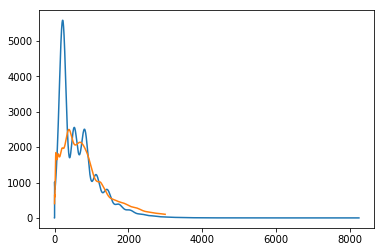

In [38]:

pars = camb.CAMBparams()
pars.set_cosmology(**cos_dict)
pars.InitPower.set_params(As=2.10058296e-9, ns=0.96605, r =0)
pars.set_for_lmax(10000, lens_potential_accuracy=0);
results = camb.get_results(pars)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
totCL=powers['total']
cl_t = totCL[:,0]
ls = np.arange(len(cl_t))
plt.plot(ls, cl_t)
ls1 = np.arange(len(yt))
plt.plot(ls1 , yt+zt+tt)

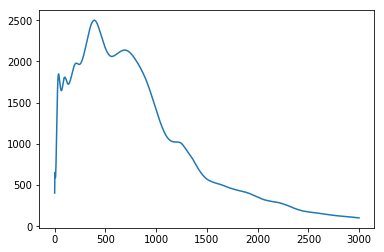

In [37]:
ls1 = np.arange(len(yt))
plt.plot(ls1 , yt+zt+tt)